In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mean_std_data = datasets.FashionMNIST('./FashionMNIST_data', train=True, download=True, transform=transforms.ToTensor()).train_data.float() / 255
mean = torch.mean(mean_std_data)
std = torch.std(mean_std_data)
print(mean, std)

tensor(0.2860) tensor(0.3530)


In [3]:
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
           ])

In [4]:
def fashion_mnist(batch_size=50, valid=0, shuffle=True, transform=fashion_transform, path='./FashionMNIST_data'):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [5]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(256)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc4(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [12]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [13]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    
    train_loss = {k: 0. for k in models}
    correct_train = {k: 0. for k in models}
    
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
            train_loss[k] += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct_train[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
        
    if log is not None:
        for k in models:
            train_loss[k] /= train_size
        correct_pct = {k: 100. * correct_train[k] / train_size for k in correct_train}
        for k in models:
            log[k].append((train_loss[k], correct_pct[k])) 

In [14]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [15]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.314291 bn: 2.323320 drop: 2.330388 both: 2.313119
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.606001 bn: 0.589110 drop: 0.683441 both: 0.654830
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.625875 bn: 0.523193 drop: 0.649096 both: 0.622459
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.458707 bn: 0.429057 drop: 0.511233 both: 0.444695
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.393171 bn: 0.436142 drop: 0.422594 both: 0.456806
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.647372 bn: 0.587240 drop: 0.705814 both: 0.614349
Test set:
default: Loss: 0.4421	Accuracy: 8405.0/10000 (84%)
bn: Loss: 0.4221	Accuracy: 8469.0/10000 (85%)
drop: Loss: 0.4711	Accuracy: 8308.0/10000 (83%)
both: Loss: 0.4436	Accuracy: 8441.0/10000 (84%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.482204 bn: 0.492322 drop: 0.514593 both: 0.541984
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.488415 bn: 0.420627 drop: 0.494

Train Epoch: 11 [10000/50000 (20%)]	Losses default: 0.275017 bn: 0.211221 drop: 0.284674 both: 0.196492
Train Epoch: 11 [20000/50000 (40%)]	Losses default: 0.211810 bn: 0.148379 drop: 0.226556 both: 0.183268
Train Epoch: 11 [30000/50000 (60%)]	Losses default: 0.535692 bn: 0.387170 drop: 0.573931 both: 0.435779
Train Epoch: 11 [40000/50000 (80%)]	Losses default: 0.265016 bn: 0.236613 drop: 0.258281 both: 0.199549
Train Epoch: 11 [50000/50000 (100%)]	Losses default: 0.177231 bn: 0.119458 drop: 0.165928 both: 0.174757
Test set:
default: Loss: 0.3085	Accuracy: 8869.0/10000 (89%)
bn: Loss: 0.3014	Accuracy: 8911.0/10000 (89%)
drop: Loss: 0.3284	Accuracy: 8781.0/10000 (88%)
both: Loss: 0.3054	Accuracy: 8908.0/10000 (89%)

Train Epoch: 12 [0/50000 (0%)]	Losses default: 0.194599 bn: 0.239750 drop: 0.220014 both: 0.170592
Train Epoch: 12 [10000/50000 (20%)]	Losses default: 0.269410 bn: 0.283905 drop: 0.281774 both: 0.337484
Train Epoch: 12 [20000/50000 (40%)]	Losses default: 0.181175 bn: 0.23632

Train Epoch: 21 [10000/50000 (20%)]	Losses default: 0.300968 bn: 0.254784 drop: 0.317695 both: 0.225129
Train Epoch: 21 [20000/50000 (40%)]	Losses default: 0.161115 bn: 0.201353 drop: 0.164979 both: 0.228215
Train Epoch: 21 [30000/50000 (60%)]	Losses default: 0.156493 bn: 0.134728 drop: 0.169956 both: 0.149699
Train Epoch: 21 [40000/50000 (80%)]	Losses default: 0.143448 bn: 0.197352 drop: 0.193795 both: 0.161058
Train Epoch: 21 [50000/50000 (100%)]	Losses default: 0.179999 bn: 0.142331 drop: 0.180043 both: 0.133627
Test set:
default: Loss: 0.3133	Accuracy: 8943.0/10000 (89%)
bn: Loss: 0.3254	Accuracy: 8921.0/10000 (89%)
drop: Loss: 0.3139	Accuracy: 8925.0/10000 (89%)
both: Loss: 0.3134	Accuracy: 8954.0/10000 (90%)

Train Epoch: 22 [0/50000 (0%)]	Losses default: 0.117114 bn: 0.079108 drop: 0.127640 both: 0.083187
Train Epoch: 22 [10000/50000 (20%)]	Losses default: 0.159261 bn: 0.163684 drop: 0.125514 both: 0.235456
Train Epoch: 22 [20000/50000 (40%)]	Losses default: 0.135430 bn: 0.06847

Train Epoch: 31 [10000/50000 (20%)]	Losses default: 0.050773 bn: 0.039023 drop: 0.057225 both: 0.032985
Train Epoch: 31 [20000/50000 (40%)]	Losses default: 0.054172 bn: 0.049327 drop: 0.099910 both: 0.105690
Train Epoch: 31 [30000/50000 (60%)]	Losses default: 0.124335 bn: 0.118428 drop: 0.178988 both: 0.143211
Train Epoch: 31 [40000/50000 (80%)]	Losses default: 0.204601 bn: 0.221974 drop: 0.200158 both: 0.241586
Train Epoch: 31 [50000/50000 (100%)]	Losses default: 0.118536 bn: 0.140223 drop: 0.182010 both: 0.227673
Test set:
default: Loss: 0.3556	Accuracy: 8936.0/10000 (89%)
bn: Loss: 0.3455	Accuracy: 8982.0/10000 (90%)
drop: Loss: 0.3501	Accuracy: 8920.0/10000 (89%)
both: Loss: 0.3540	Accuracy: 8979.0/10000 (90%)

Train Epoch: 32 [0/50000 (0%)]	Losses default: 0.150451 bn: 0.093520 drop: 0.181802 both: 0.133094
Train Epoch: 32 [10000/50000 (20%)]	Losses default: 0.053962 bn: 0.053093 drop: 0.095988 both: 0.047292
Train Epoch: 32 [20000/50000 (40%)]	Losses default: 0.073162 bn: 0.06481

Train Epoch: 41 [10000/50000 (20%)]	Losses default: 0.204158 bn: 0.194972 drop: 0.131952 both: 0.326203
Train Epoch: 41 [20000/50000 (40%)]	Losses default: 0.101324 bn: 0.060727 drop: 0.046338 both: 0.104193
Train Epoch: 41 [30000/50000 (60%)]	Losses default: 0.123621 bn: 0.071679 drop: 0.091645 both: 0.061695
Train Epoch: 41 [40000/50000 (80%)]	Losses default: 0.043513 bn: 0.086732 drop: 0.050698 both: 0.120536
Train Epoch: 41 [50000/50000 (100%)]	Losses default: 0.028725 bn: 0.123253 drop: 0.029059 both: 0.043548
Test set:
default: Loss: 0.4153	Accuracy: 8948.0/10000 (89%)
bn: Loss: 0.4015	Accuracy: 8926.0/10000 (89%)
drop: Loss: 0.4042	Accuracy: 8915.0/10000 (89%)
both: Loss: 0.3989	Accuracy: 8944.0/10000 (89%)

Train Epoch: 42 [0/50000 (0%)]	Losses default: 0.095472 bn: 0.068600 drop: 0.165439 both: 0.117341
Train Epoch: 42 [10000/50000 (20%)]	Losses default: 0.063510 bn: 0.142215 drop: 0.136083 both: 0.078062
Train Epoch: 42 [20000/50000 (40%)]	Losses default: 0.039502 bn: 0.08978

Train Epoch: 51 [10000/50000 (20%)]	Losses default: 0.023752 bn: 0.046136 drop: 0.104491 both: 0.132485
Train Epoch: 51 [20000/50000 (40%)]	Losses default: 0.072301 bn: 0.062575 drop: 0.110652 both: 0.186653
Train Epoch: 51 [30000/50000 (60%)]	Losses default: 0.015848 bn: 0.015566 drop: 0.046627 both: 0.065718
Train Epoch: 51 [40000/50000 (80%)]	Losses default: 0.208080 bn: 0.150964 drop: 0.091495 both: 0.127236
Train Epoch: 51 [50000/50000 (100%)]	Losses default: 0.026892 bn: 0.082673 drop: 0.014597 both: 0.091964
Test set:
default: Loss: 0.4700	Accuracy: 8923.0/10000 (89%)
bn: Loss: 0.4417	Accuracy: 8932.0/10000 (89%)
drop: Loss: 0.4570	Accuracy: 8884.0/10000 (89%)
both: Loss: 0.4372	Accuracy: 8926.0/10000 (89%)

Train Epoch: 52 [0/50000 (0%)]	Losses default: 0.038923 bn: 0.011382 drop: 0.013933 both: 0.036488
Train Epoch: 52 [10000/50000 (20%)]	Losses default: 0.044963 bn: 0.038219 drop: 0.079011 both: 0.100422
Train Epoch: 52 [20000/50000 (40%)]	Losses default: 0.117918 bn: 0.02380

Train Epoch: 61 [10000/50000 (20%)]	Losses default: 0.047771 bn: 0.068168 drop: 0.026745 both: 0.075410
Train Epoch: 61 [20000/50000 (40%)]	Losses default: 0.016158 bn: 0.028170 drop: 0.004491 both: 0.075255
Train Epoch: 61 [30000/50000 (60%)]	Losses default: 0.009786 bn: 0.012649 drop: 0.022667 both: 0.065239
Train Epoch: 61 [40000/50000 (80%)]	Losses default: 0.042473 bn: 0.132254 drop: 0.029663 both: 0.022263
Train Epoch: 61 [50000/50000 (100%)]	Losses default: 0.057799 bn: 0.021788 drop: 0.094020 both: 0.030992
Test set:
default: Loss: 0.5453	Accuracy: 8932.0/10000 (89%)
bn: Loss: 0.4982	Accuracy: 8946.0/10000 (89%)
drop: Loss: 0.5078	Accuracy: 8928.0/10000 (89%)
both: Loss: 0.4721	Accuracy: 8952.0/10000 (90%)

Train Epoch: 62 [0/50000 (0%)]	Losses default: 0.024184 bn: 0.024340 drop: 0.023157 both: 0.049054
Train Epoch: 62 [10000/50000 (20%)]	Losses default: 0.036198 bn: 0.027490 drop: 0.019709 both: 0.033501
Train Epoch: 62 [20000/50000 (40%)]	Losses default: 0.024435 bn: 0.03613

Train Epoch: 71 [10000/50000 (20%)]	Losses default: 0.002504 bn: 0.022510 drop: 0.004685 both: 0.045072
Train Epoch: 71 [20000/50000 (40%)]	Losses default: 0.029931 bn: 0.055527 drop: 0.013390 both: 0.048658
Train Epoch: 71 [30000/50000 (60%)]	Losses default: 0.076249 bn: 0.109620 drop: 0.183749 both: 0.031608
Train Epoch: 71 [40000/50000 (80%)]	Losses default: 0.000920 bn: 0.003506 drop: 0.003417 both: 0.050270
Train Epoch: 71 [50000/50000 (100%)]	Losses default: 0.023892 bn: 0.038337 drop: 0.012018 both: 0.059310
Test set:
default: Loss: 0.6232	Accuracy: 8854.0/10000 (89%)
bn: Loss: 0.5216	Accuracy: 8974.0/10000 (90%)
drop: Loss: 0.5325	Accuracy: 8939.0/10000 (89%)
both: Loss: 0.5221	Accuracy: 8895.0/10000 (89%)

Train Epoch: 72 [0/50000 (0%)]	Losses default: 0.024133 bn: 0.013708 drop: 0.018529 both: 0.082717
Train Epoch: 72 [10000/50000 (20%)]	Losses default: 0.030929 bn: 0.020841 drop: 0.034795 both: 0.024456
Train Epoch: 72 [20000/50000 (40%)]	Losses default: 0.081785 bn: 0.06209

Train Epoch: 81 [10000/50000 (20%)]	Losses default: 0.005669 bn: 0.007688 drop: 0.021356 both: 0.047946
Train Epoch: 81 [20000/50000 (40%)]	Losses default: 0.027622 bn: 0.009118 drop: 0.003412 both: 0.003989
Train Epoch: 81 [30000/50000 (60%)]	Losses default: 0.030634 bn: 0.007921 drop: 0.016254 both: 0.028268
Train Epoch: 81 [40000/50000 (80%)]	Losses default: 0.000893 bn: 0.027197 drop: 0.011150 both: 0.038628
Train Epoch: 81 [50000/50000 (100%)]	Losses default: 0.003201 bn: 0.006488 drop: 0.012847 both: 0.072395
Test set:
default: Loss: 0.6610	Accuracy: 8937.0/10000 (89%)
bn: Loss: 0.5602	Accuracy: 8957.0/10000 (90%)
drop: Loss: 0.5979	Accuracy: 8945.0/10000 (89%)
both: Loss: 0.5243	Accuracy: 8951.0/10000 (90%)

Train Epoch: 82 [0/50000 (0%)]	Losses default: 0.022239 bn: 0.061750 drop: 0.016969 both: 0.056192
Train Epoch: 82 [10000/50000 (20%)]	Losses default: 0.010991 bn: 0.018260 drop: 0.015980 both: 0.011030
Train Epoch: 82 [20000/50000 (40%)]	Losses default: 0.002824 bn: 0.01431

Train Epoch: 91 [10000/50000 (20%)]	Losses default: 0.043868 bn: 0.010045 drop: 0.008471 both: 0.106872
Train Epoch: 91 [20000/50000 (40%)]	Losses default: 0.031445 bn: 0.047962 drop: 0.020271 both: 0.061288
Train Epoch: 91 [30000/50000 (60%)]	Losses default: 0.001723 bn: 0.002965 drop: 0.007082 both: 0.010801
Train Epoch: 91 [40000/50000 (80%)]	Losses default: 0.041355 bn: 0.002330 drop: 0.066387 both: 0.003620
Train Epoch: 91 [50000/50000 (100%)]	Losses default: 0.002114 bn: 0.004979 drop: 0.000274 both: 0.027382
Test set:
default: Loss: 0.7272	Accuracy: 8894.0/10000 (89%)
bn: Loss: 0.5916	Accuracy: 8922.0/10000 (89%)
drop: Loss: 0.6249	Accuracy: 8917.0/10000 (89%)
both: Loss: 0.6076	Accuracy: 8846.0/10000 (88%)

Train Epoch: 92 [0/50000 (0%)]	Losses default: 0.000556 bn: 0.003534 drop: 0.004124 both: 0.010128
Train Epoch: 92 [10000/50000 (20%)]	Losses default: 0.030325 bn: 0.009660 drop: 0.006422 both: 0.096034
Train Epoch: 92 [20000/50000 (40%)]	Losses default: 0.001614 bn: 0.02251

In [16]:
def plot_compare_logs(test_log, train_log):
    keys = test_log.keys()
    test_logs = {k:[z for z in zip(*test_log[k])] for k in keys}
    train_logs = {k:[z for z in zip(*train_log[k])] for k in keys}
    epochs = {k:range(len(test_log[k])) for k in keys}
    
    g_counter = 0
    for k in keys:        
        plt.subplot(4, 2, g_counter+1)
        plt.plot(epochs[k], test_logs[k][0], label='test loss')
        plt.plot(epochs[k], train_logs[k][0], label='train loss')
        plt.title(k + ' errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid()
        
        plt.subplot(4, 2, g_counter+2)
        plt.plot(epochs[k], test_logs[k][1], label='test accuracy')
        plt.plot(epochs[k], train_logs[k][1], label='train accuracy')
        plt.title(k + ' accuracy')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid()
        
        g_counter += 2

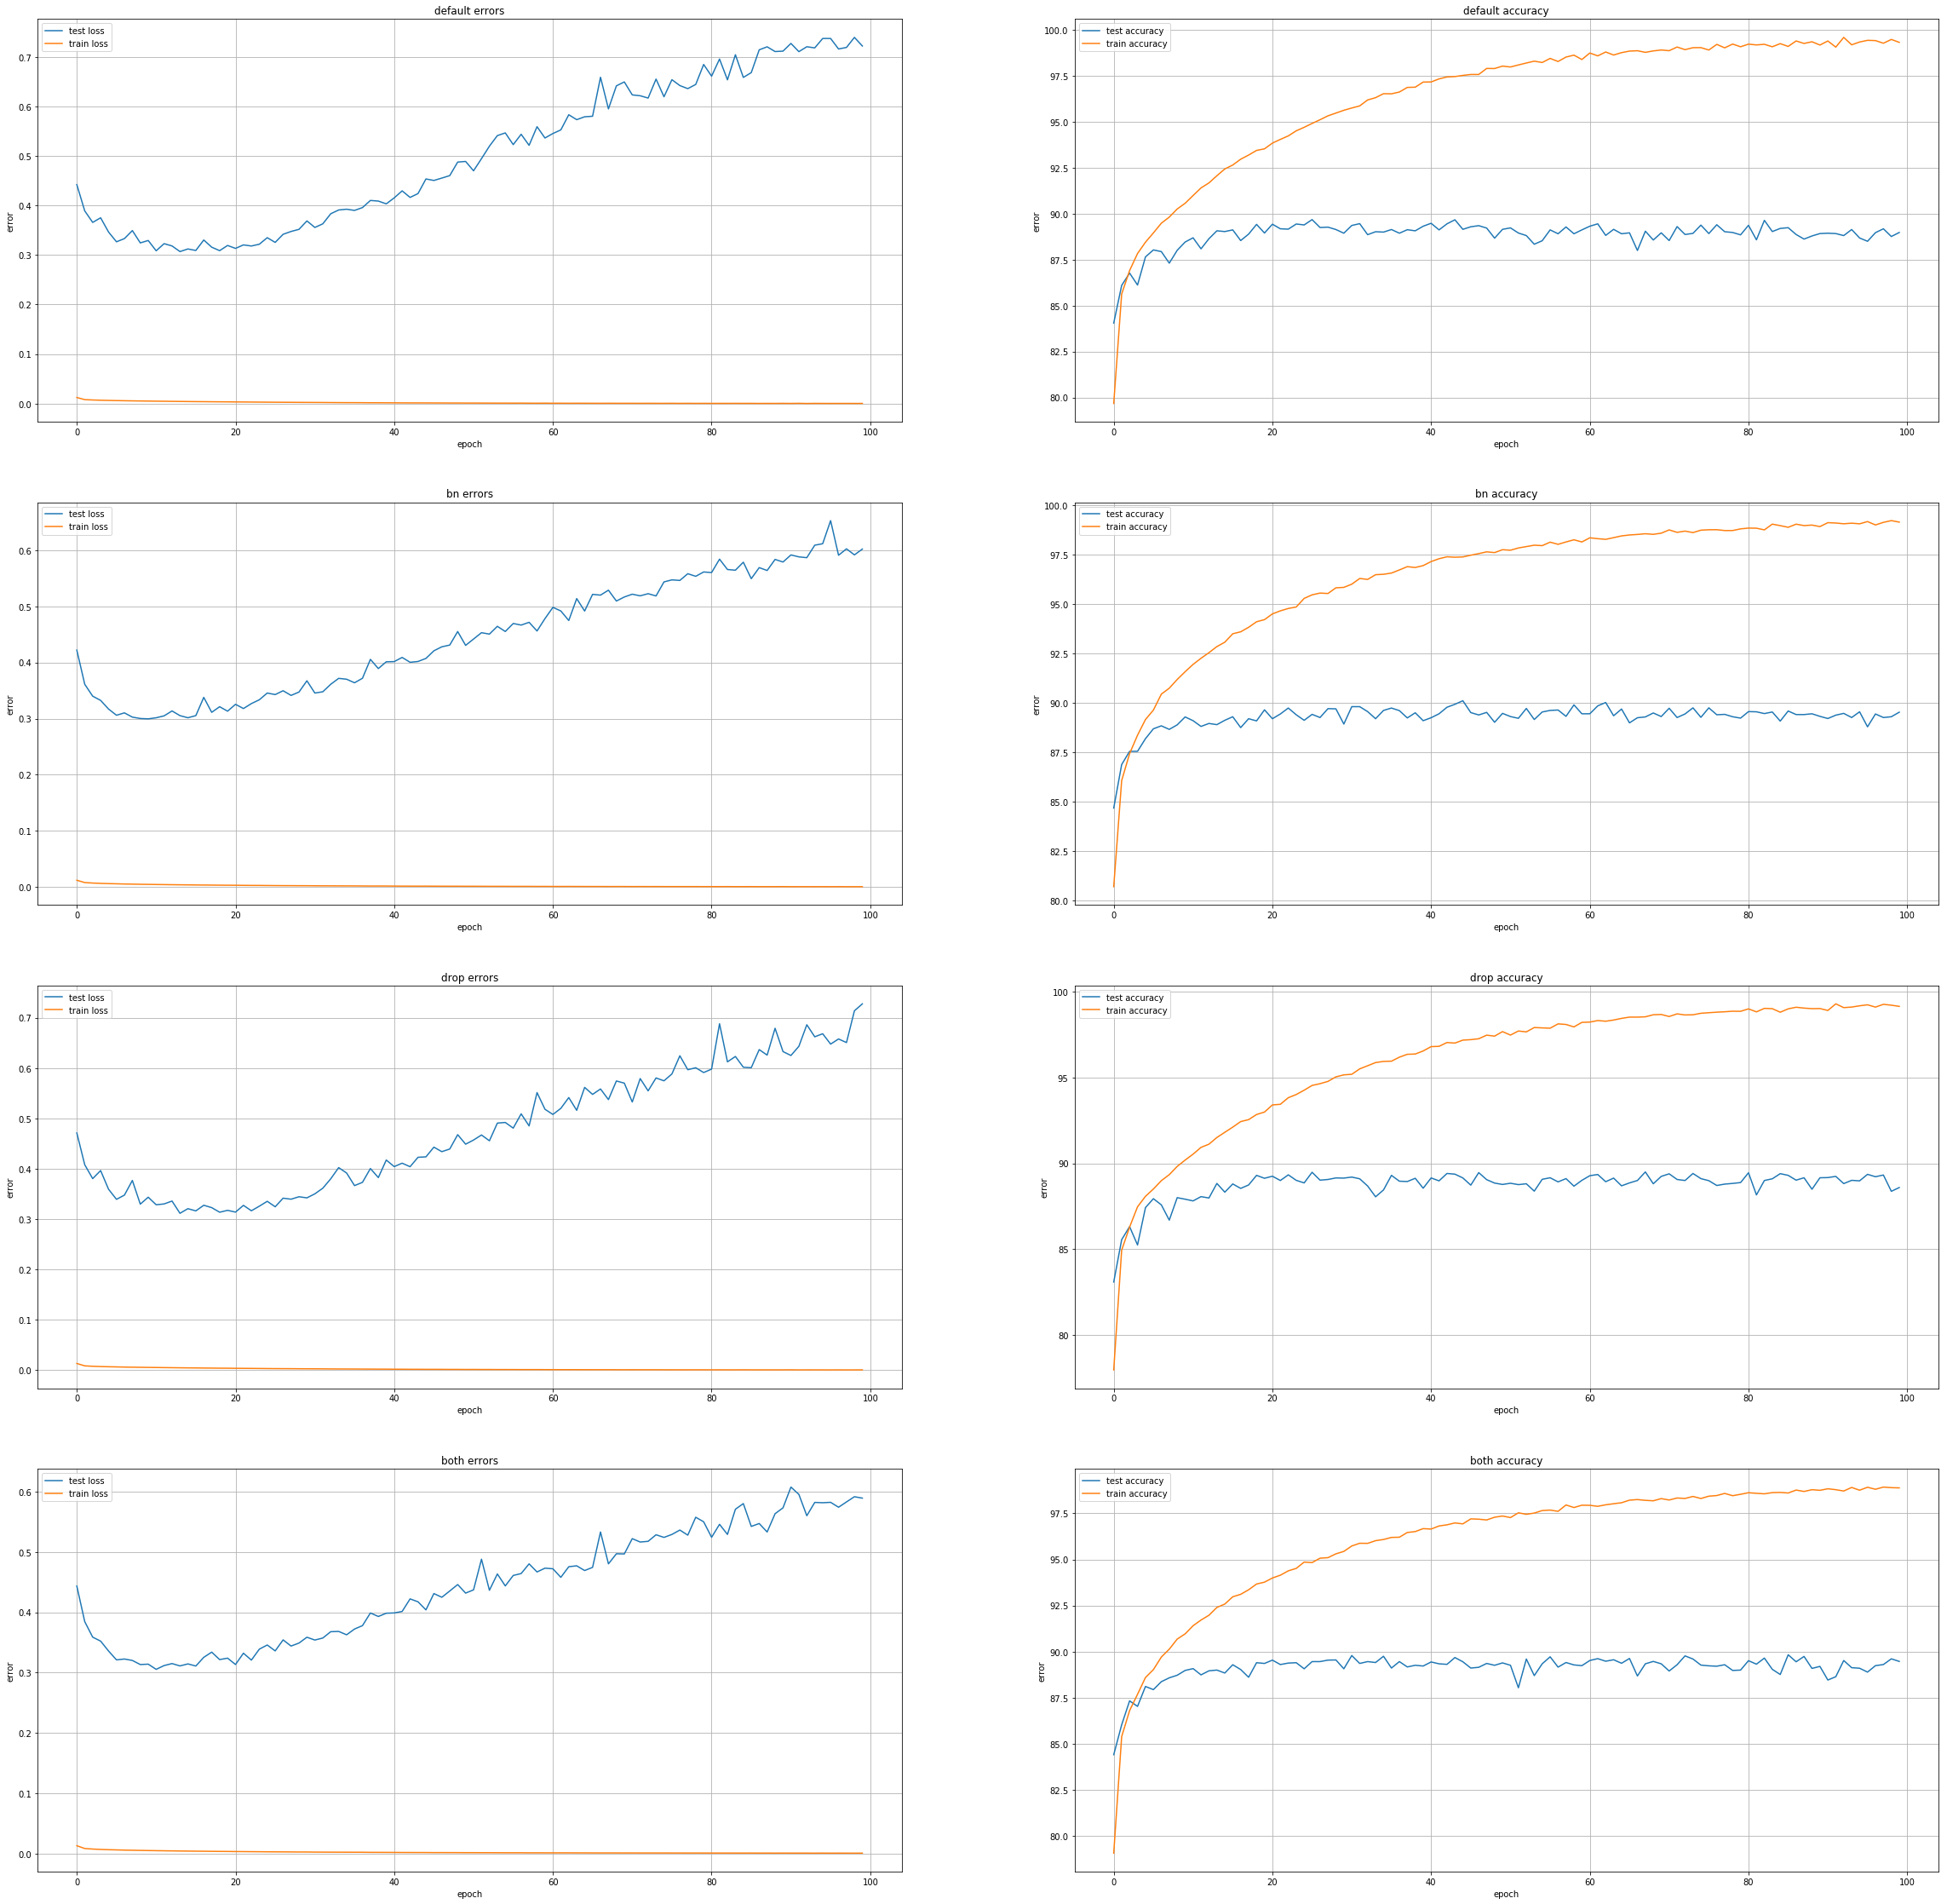

In [17]:
plt.rcParams['figure.figsize'] = [40, 40]
plot_compare_logs(test_log, train_log)